Using Tom Barclay's xoflares on EPIC-246301900, with a GP twist

In [1]:
import sys
sys.version

'3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 20:58:55) \n[Clang 11.0.0 ]'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.4.4
1.0.4
3.9.3
1.11.3


In [5]:
"""
lc = search.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())
"""

"\nlc = search.search_targetpixelfile('EPIC 246301900').download()\nlc.to_lightcurve().plot()\nref_time = 0.5 * (lc.time.min() + lc.time.max())\n"

In [6]:
"""lc = lc.to_lightcurve()
print(lc.flux.shape)
"""

'lc = lc.to_lightcurve()\nprint(lc.flux.shape)\n'

In [4]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [5]:
fits.getheader(filename)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-02-28'         / file creation date.                            
CREATOR = '1003547 FluxExporter2PipelineModule' / pipeline job and program used 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.109 r63647' / SW version  
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [6]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

In [7]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))

pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data
superflare = lc.loc[1569:1655] # area around the superflare

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

# calculate normalized flux
def normalize_flux(lc):
    return (lc/np.median(lc)) - 1

def normalize_error(array):
    return array

3255


1      -0.015936
2      -0.015972
3      -0.016081
4      -0.015839
5      -0.014598
          ...   
1607    0.000469
1608    0.000106
1609    0.000113
1610   -0.000049
1611   -0.000154
Name: PDCSAP_FLUX, Length: 1511, dtype: float32
1      -0.022793
2      -0.022212
3      -0.021701
4      -0.021135
5      -0.019555
          ...   
1607    0.002953
1608    0.002748
1609    0.002756
1610    0.002878
1611    0.003286
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32


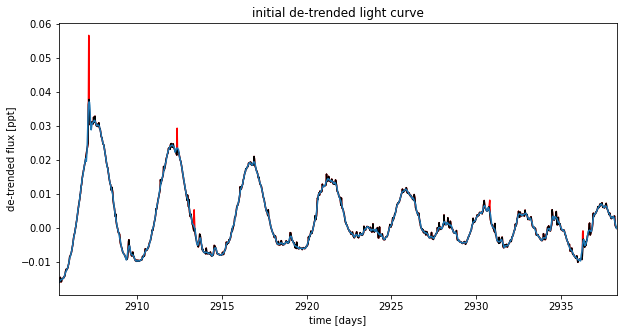

In [72]:
# get a smoothed version of the light curve
norm_y = normalize_flux(pre.PDCSAP_FLUX)

norm_yerr = normalize_flux(pre.PDCSAP_FLUX_ERR)
print(norm_y)
print(norm_yerr) # how to deal with errors in normalized time series? 

smooth = savgol_filter(norm_y, 13, polyorder=3)
resid = norm_y - smooth
mask = resid < 3.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(pre.TIME, norm_y, "r")
plt.plot(pre.TIME[mask], norm_y[mask], "k")
plt.plot(pre.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(pre.TIME.min(), pre.TIME.max());

### Gameplan: Get flares first. Subtract flares. Feed smoother light curve into pyMC machinery to get posteriors for star

### Flares

In [9]:
def find_flares(lc):

    # find some flares
    mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
    #lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    print(tpeaks, ampls, fwhms, npeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(pre)

[-14.69051155  -9.48030758  -8.47913517   8.94926485  14.42495513] [0.02022774 0.00583337 0.00504719 0.00336644 0.00339113] [0.00277778 0.00277778 0.00277778 0.00277778 0.00277778] 5


In [ ]:
"""# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());
"""

**Check if times of predicted flares match up**

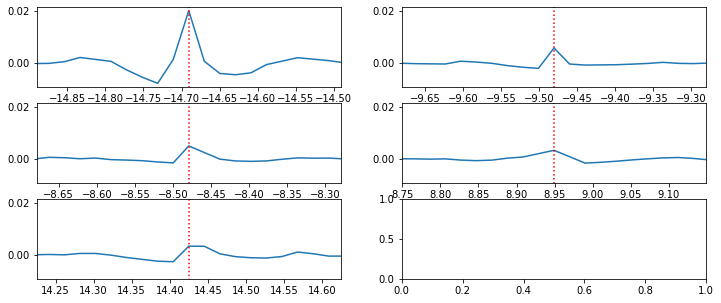

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

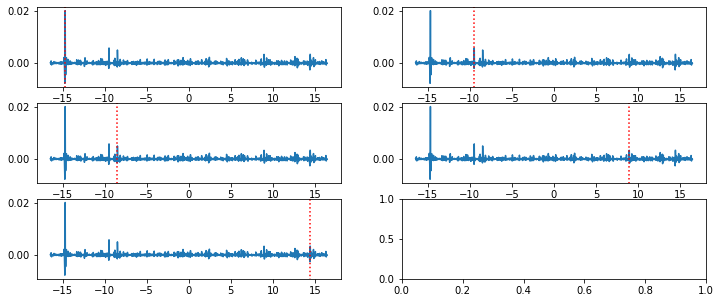

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')
    #ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))


In [12]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [ ]:
# USING GPs TO CALCULATE LIKELIHOODS
with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=2000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

In [13]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -1.3166292014623162e+21 -> -1.302401510740493e+21
optimizing logp for variables: [mean, logAmpl]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -1.302401510740493e+21 -> -1.302133301589577e+21
optimizing logp for variables: [logAmpl, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -1.302133301589577e+21 -> -1.3016250368397235e+21
optimizing logp for variables: [tpeak]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -1.3016250368397235e+21 -> -1.3016250368397235e+21


Finished [100%]: Average Loss = -8,957.5


In [14]:
start[0]['tpeak'] - 0.2

array([-14.89066275,  -9.68063096,  -8.67920796,   8.74842636,
        14.23062906])

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

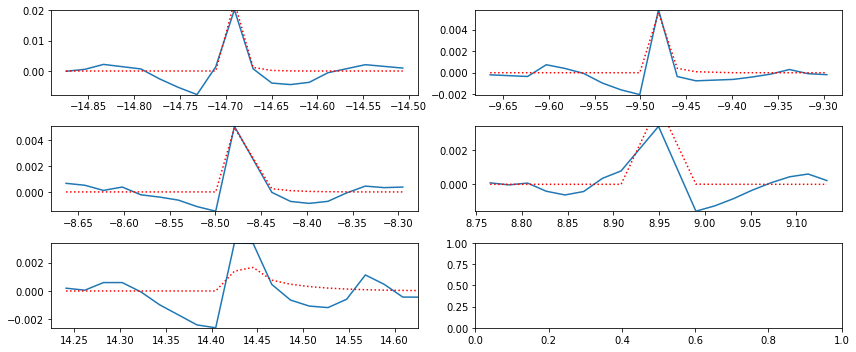

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [16]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [17]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 4691 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logAmpl[0],-3.181,0.523,-3.923,-2.217,0.030,0.021,298.0,298.0,331.0,807.0,1.01
logAmpl[1],-4.501,0.529,-5.268,-3.486,0.014,0.010,1472.0,1472.0,1611.0,2548.0,1.00
logAmpl[2],-4.699,0.495,-5.455,-3.755,0.011,0.008,1906.0,1906.0,2142.0,3026.0,1.00
logAmpl[3],-5.129,0.521,-5.942,-4.084,0.009,0.006,3363.0,3363.0,3972.0,3472.0,1.00
logAmpl[4],-3.675,0.564,-4.786,-2.600,0.014,0.010,1566.0,1566.0,1602.0,1199.0,1.01
logFwhm[0],-6.456,0.405,-7.222,-5.794,0.011,0.008,1471.0,1457.0,1702.0,1842.0,1.00
logFwhm[1],-6.325,0.584,-7.440,-5.252,0.009,0.006,4353.0,4228.0,4547.0,4008.0,1.00
logFwhm[2],-5.927,0.651,-7.161,-4.764,0.010,0.007,4103.0,4020.0,4278.0,5180.0,1.00
logFwhm[3],-6.074,0.632,-7.306,-4.933,0.008,0.006,5717.0,5600.0,5837.0,4774.0,1.00
logFwhm[4],-5.358,0.347,-5.988,-4.713,0.008,0.006,1812.0,1806.0,1789.0,1487.0,1.00


In [19]:
trace['flare_lc'].shape

(9600, 1511)

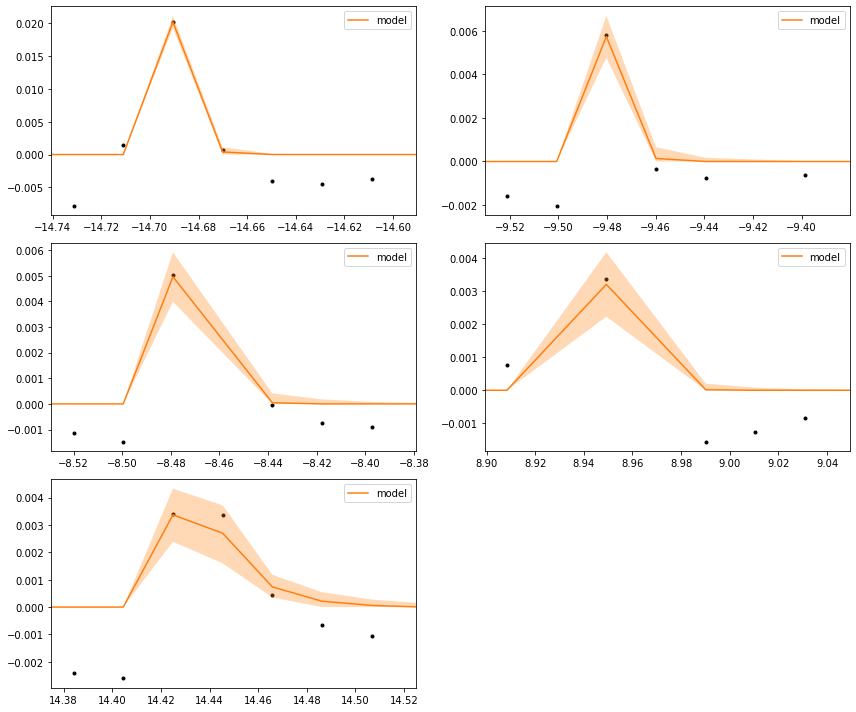

In [20]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1000 + np.max(y[timemask]))
    ax.legend()
    
fig.delaxes(axes[5]) 
fig.tight_layout()
fig.savefig('flare-model-preflare.png')


In [61]:
# save out to combine with other two set of flares
#pd.Series(flc[1]).to_csv('pre-flare-flares.csv', index=False)

In [22]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

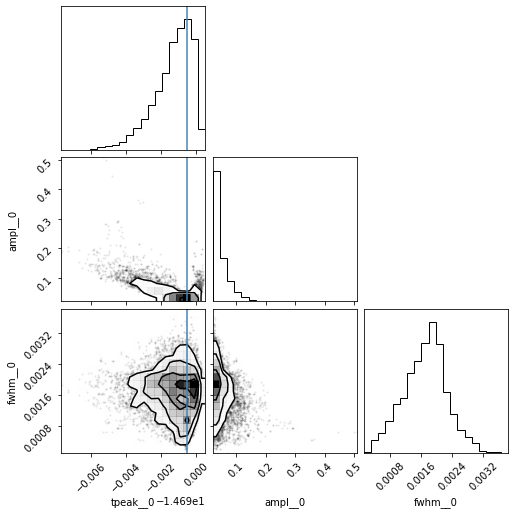

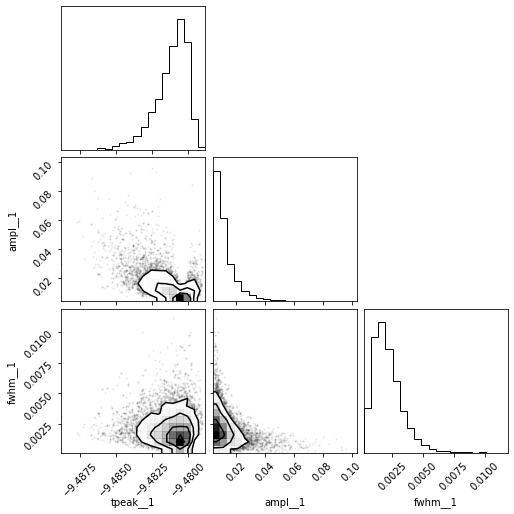

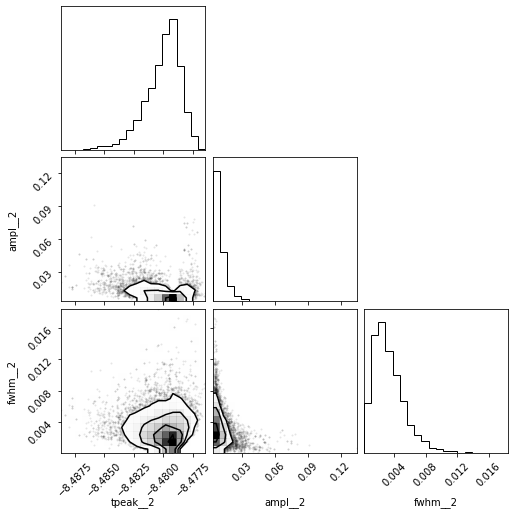

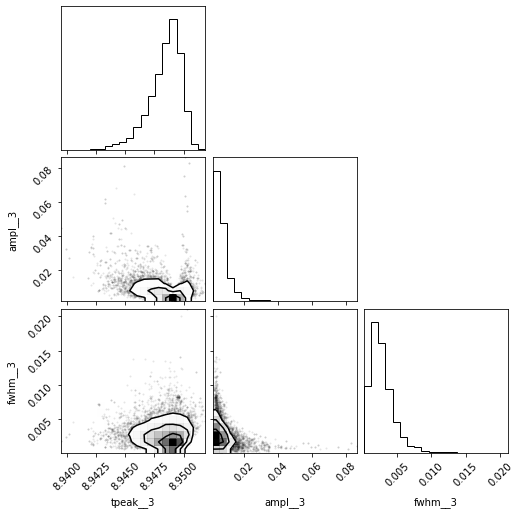

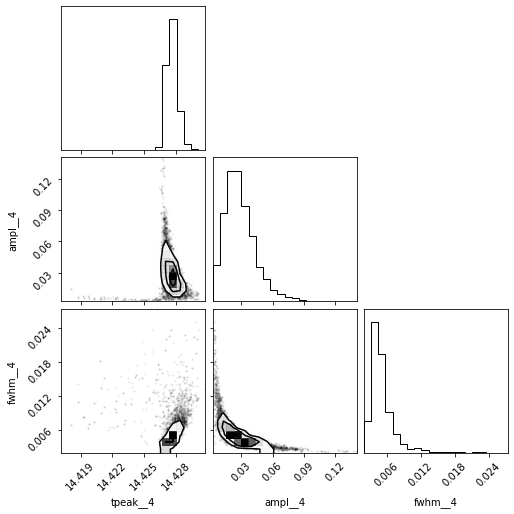

In [23]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

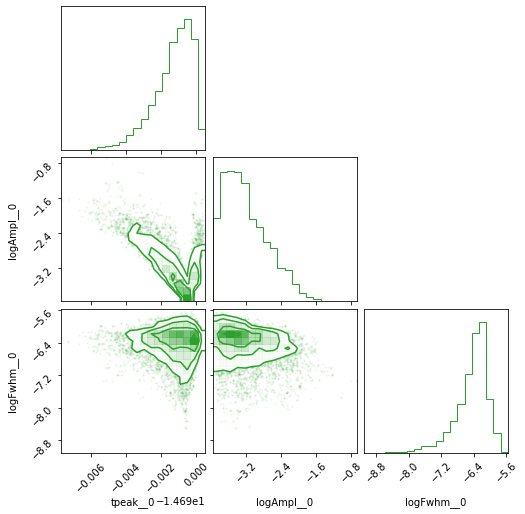

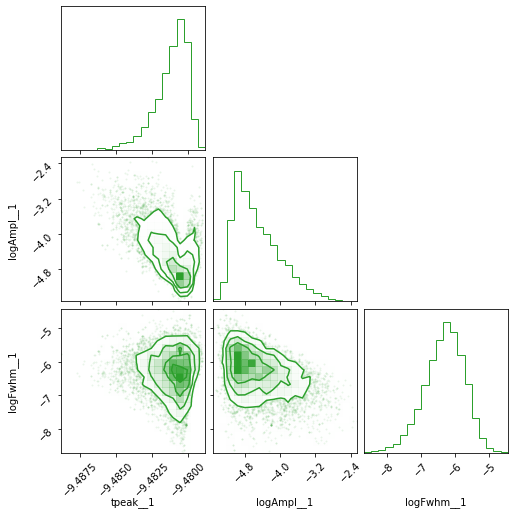

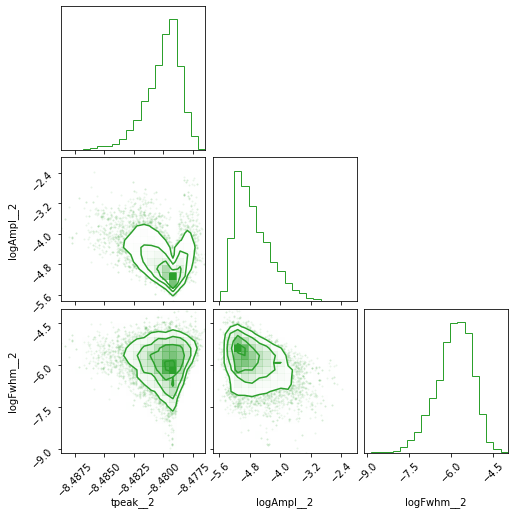

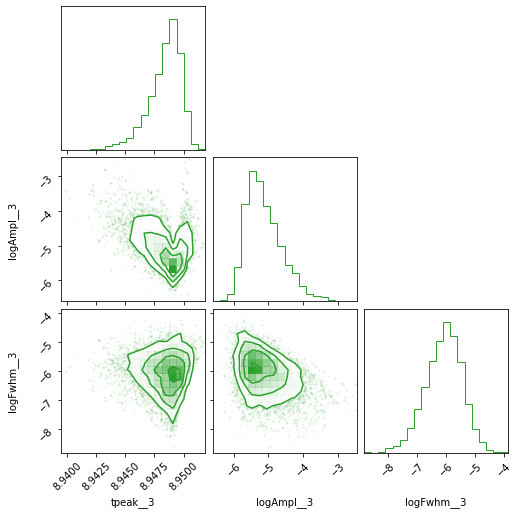

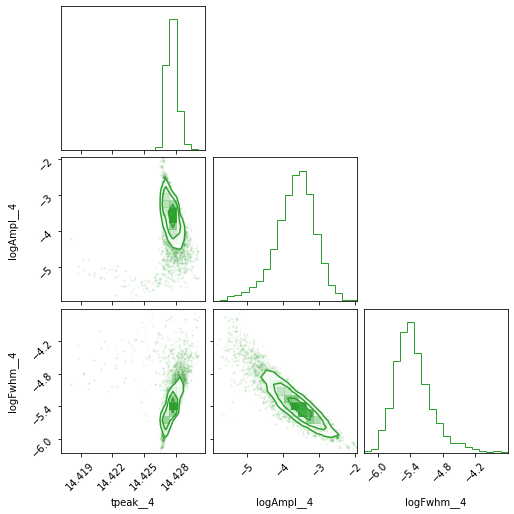

In [24]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');

#### Measuring Flare Energy

From Doyle et al 2018 "Investigating the rotational phase of stellar flares on M dwarfs using K2 short cadence data"

"To determine the energy of the stellar flares, the quiescent luminosity of the star, L_star, must be calculated in the Kepler bandpass. To construct a template spectral energy distribution for each star we used PanStarrs magnitudes g, r, i, and z (see Table A1). The PanStarrs magnitudes (Chambers et al. 2016) represent the mean quiescent magnitude of the star calculated over an average of multiple measurements. This ensures the effects of flares or rotation has been removed from the magnitudes. We fitted a polynomial to the Panstarrs data and determined the flux in the Keplerbandpass in the same manner as Kowalski et al. (2013). The quiescent luminosity is then computed by multiplying the flux by 4πd2, where the distance (d) to the stars has been determined by inverting the parallax from the Gaia Data 2 release (Gaia Collaboration et al. 2016, 2018; see Table 3)...The energy of the flares, Eflare, can then be determined by the multiplication of the luminosity of the star, L*, in erg s−1 and the equivalent duration, t, in seconds. The equivalent duration (Gershberg 1972) is defined as the area under the flare light curve in units of seconds"

OR, from Davenport 2016 "THE KEPLER CATALOG OF STELLAR FLARES": <br>

"For this reason it
better to not assume a single flare spectrum, and instead
I estimate the distance and luminosity for each star to
determine it’s quiescent luminosity.
The Kepler Input Catalog provides ground-based photometry for all available stars in the Kepler field of view.
Using Version 10 of this catalog
, I obtained the g, Ks,
and Kp (Kepler) photometry for every star in the sample. The g − Ks color is then used to place each star
on to a stellar isochrone model, which gives an absolute
magnitude and mass for each star. Typical photometric
uncertainties from the g − Ks color propagate to mass
uncertainties of ∼0.02 M_star. This assumes that all stars
in the sample are on the isochrone’s main sequence. A 1-
Gyr isochrone from the PARSEC models (Bressan et al.
2012) with Z=0.019 and no dust extinction is used. Note
this will yield an incorrect distance for giant and subgiant stars. The star’s absolute g, Ks, and Kp (Kepler)
magnitudes are determined by linearly interpolating the
observed g − K color to the gridded values from the
isochrone. The apparent Ks magnitude for each star is
used to determine the distance modulus. The isochronederived absolute Kp magnitude is finally converted from
AB magnitudes to a quiescent luminosity, which is denoted LKp, and is used to convert flare ED’s to energies. The resulting flare energy that is calculated does
not correct for the spectrum of the flare through the
Kepler bandpass, or for the flare energy emitted outside
the Kepler bandpass, as discussed more in §6."

Get Kepler magnitude<br> (https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml; Smith et al (ApJ 123, 2121, 2002, Table 7)) <br><br>
Convert from AB magnitude to quiescent luminosity<br> (Davenport 2016; https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions; Oke, J.B. 1974, ApJS, 27, 21)

In [25]:
# flare energy = L_star * ed
# ed = area under the curve
# L_star = 4 * pi * d**2 * luminosity_q
# d = 1/parallax
# luminosity_q = average g, r, i, z magnitudes???
g = 12.076
r = 10.864
i = 10.228
parallax = 21.6345 # in milliarcsecs (mas)
distance = 1./(parallax*0.001) # parsecs
#distance = 22.74 # nope, use ExoFOP's value: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
print(distance)

def calculate_energy():
    #l_star = (4*np.pi*distance**2) * ((g+r+i)/3)
    lkp = (4*np.pi*distance**2) * kepmag_zeropoint_luminosity(g, r) * 4000
    print("log LKp: ", np.log10(lkp))
    ed = 0.5*86400*0.05*12000 # from eyeballing one of the flare triangles above
    print("ED: ", ed)
    return np.log10(lkp*ed) # show order of energy in ergs...needs to be ~>27
 
def kepmag_zeropoint_luminosity(g, r): 
    ### kepmag
    # greater error for M dwarfs w/Teff < 3500 K
    # https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml
    if (g-r) <= 0.8:
        kp = 0.2*g + 0.8*r
    else:
        kp = 0.1*g + 0.9*r
    #print("Kp: ", kp)
    
    # nope, use ExoFOP's value: 10.807, https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
    kp = 10.807
    
    ### zeropoint, bolometric correction, and magnitude-to-luminosity formula
    # AB mag to f, then multiply by Kepler filter FWHM of 4000 Angstroms
    # per https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    # and https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    
    #pre_lkp = 4000 * np.exp(-(kp+48.6)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    #pre_lkp = 4000 * np.exp(-(kp+4.81)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://academic.oup.com/mnras/article/433/2/1133/1747991
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(4.81-kp)) # Eqn 3 in https://academic.oup.com/mnras/article/433/2/1133/1747991
    pre_lkp = l_sun * np.power(10, 0.4*(-20.24-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    #f12 = 1.74e5 # e-/s, per https://keplergo.arc.nasa.gov/CalibrationSN.shtml
    #pre_lkp = f12 * np.power(10, 0.4*(12-kp))
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    return pre_lkp
    
print("log flare energy: ", calculate_energy())


46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  25920000.0
log flare energy:  38.504781430082865


#### The superflare

In [26]:
print(len(pre.PDCSAP_FLUX))
print(len(post.PDCSAP_FLUX))
print(len(postgap.PDCSAP_FLUX))
print(len(pd.concat([pre.PDCSAP_FLUX, post.PDCSAP_FLUX, postgap.PDCSAP_FLUX])))

1511
671
1071
3253


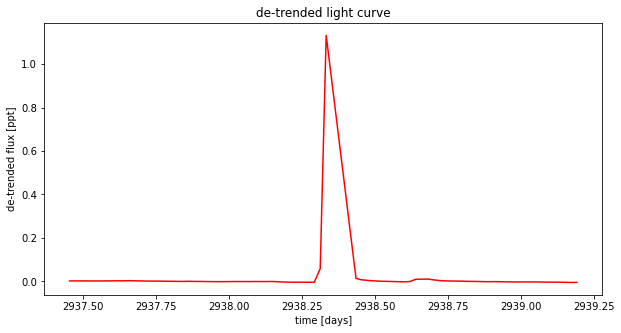

In [27]:
# get a smoothed version of the light curve
#smooth = savgol_filter(pre.PDCSAP_FLUX, 13, polyorder=3)
#resid = pre.PDCSAP_FLUX - smooth
#mask = resid < 3.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
#detrended_superflare = superflare.PDCSAP_FLUX-np.ones(len(superflare))*np.median(superflare.PDCSAP_FLUX)
#detrended_superflare = normalize_flux(pd.concat([pre.PDCSAP_FLUX, post.PDCSAP_FLUX, postgap.PDCSAP_FLUX]))
detrended_superflare = normalize_flux(superflare.PDCSAP_FLUX)
plt.plot(superflare.TIME, detrended_superflare, "r")
#plt.plot(superflare.TIME[mask], superflare.PDCSAP_FLUX[mask], "k")
#plt.plot(pre.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("de-trended light curve")
#plt.ylim(580000, 680000)
#plt.xlim(superflare.TIME.min(), superflare.TIME.max())
plt.savefig('superflare.png')
plt.show()

In [28]:
# np.argmax(detrended_superflare)
detrended_superflare[35:48]

1608   -0.003623
1609   -0.003616
1610   -0.003777
1611   -0.003882
1612    0.058684
1613    1.132200
1618    0.013559
1619    0.007248
1620    0.004473
1621    0.002624
1622    0.001099
1626   -0.001930
1627   -0.000550
Name: PDCSAP_FLUX, dtype: float32

In [29]:
print(detrended_superflare[39:42])
print(superflare.TIME[39:42])

1612    0.058684
1613    1.132200
1618    0.013559
Name: PDCSAP_FLUX, dtype: float32
1612    2938.313467
1613    2938.333899
1618    2938.436057
Name: TIME, dtype: float64


Hold up...so the superflare is just a single data point? Could this be a systematics/cosmic ray type situation? This introduces challenges with calculating the equivalent duration and therefore the flare's energy. 

In [30]:
# calculate equivalent duration (ED) by trapezoidal rule
# manually delineate because of missing data
# lower bound: flux goes back to quiescence immediately, use 1618 value as 1614
# OR: follow the shape from plot and assume linear decrease back to quiescence
#print(np.trapz(superflare.PDCSAP_FLUX, superflare.TIME))
superflare_ed = np.trapz(detrended_superflare[39:42], superflare.TIME[39:42]*86400)
print(superflare_ed)

6107.628352754084


#### Flare Frequency Distribution

In [31]:
superflare.TIME[39:46]

1612    2938.313467
1613    2938.333899
1618    2938.436057
1619    2938.456488
1620    2938.476920
1621    2938.497351
1622    2938.517783
Name: TIME, dtype: float64

In [32]:
# get equivalent durations
ed_data = []
ed_model = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_data.append(np.trapz(y[timemask]*86400, x[timemask]))
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    
print(ed_data)
print(ed_model)

# and multiply with quiescent luminosity to get flare energies


[6.018382673975049, -2.1115556827857853, 6.270391564658509, 5.892384143812094, -2.2218856349969003]
[36.39008535938765, 10.376941718720959, 13.246665184702726, 11.323531303053247, 12.500271810189751]


In [33]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
print("log flare energy: ", flare_energies)

log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [36.39008535938765, 10.376941718720959, 13.246665184702726, 11.323531303053247, 12.500271810189751]
log flare energy:  [32.65212951 32.10721581 32.21325299 32.14512832 32.18806589]


In [34]:
flare_energies = np.append(flare_energies, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
print(flare_energies)

log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  6107.628352754084
[32.65212951 32.10721581 32.21325299 32.14512832 32.18806589 34.87701904]


Add flare energies from post-flare-pre-gap and post-flare-post-gap

In [35]:
#postpre_energies = [37.76185403, 37.18593888, 37.47559725, 37.2457923, 37.23747499]
#postpost_energies = [38.08577839, 38.37316533]
postpre_energies = [32.5870972,  32.02649688, 32.30485117, 32.07565027, 32.07405075]
postpost_energies =  [32.91446004, 33.19731391]
flare_energies = np.append(flare_energies, postpre_energies)
flare_energies = np.append(flare_energies, postpost_energies)
print(flare_energies)

[32.65212951 32.10721581 32.21325299 32.14512832 32.18806589 34.87701904
 32.5870972  32.02649688 32.30485117 32.07565027 32.07405075 32.91446004
 33.19731391]


In [36]:
np.linspace(32.0, 35.0, 31)

array([32. , 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.7, 32.8, 32.9, 33. ,
       33.1, 33.2, 33.3, 33.4, 33.5, 33.6, 33.7, 33.8, 33.9, 34. , 34.1,
       34.2, 34.3, 34.4, 34.5, 34.6, 34.7, 34.8, 34.9, 35. ])

[3 3 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [32.  32.1 32.2 32.3 32.4 32.5 32.6 32.7 32.8 32.9 33.  33.1 33.2 33.3
 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4 34.5 34.6 34.7
 34.8 34.9 35. ]


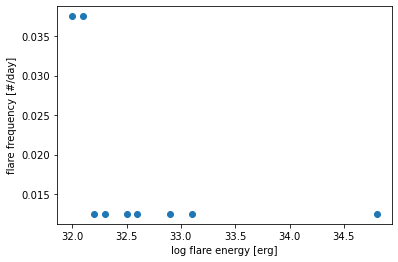

In [37]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(32.0, 35.0, 31))
print(hist, edges)
#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
plot_y = hist/80 # non log y version
plot_y[plot_y == 0] = np.log(0) # turn zeros to -infs
plt.scatter(edges[:-1], plot_y) # divided by time series length of 80 days
plt.ylabel('flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
plt.savefig('ffd.png')
plt.show()

[3 3 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [32.  32.1 32.2 32.3 32.4 32.5 32.6 32.7 32.8 32.9 33.  33.1 33.2 33.3
 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4 34.5 34.6 34.7
 34.8 34.9 35. ]


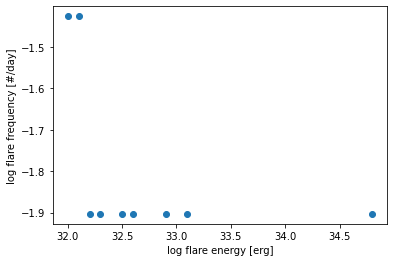

In [38]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(32.0, 35.0, 31))
print(hist, edges)
plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
#plot_y = hist/80 # non log y version
#plot_y[plot_y == 0] = np.log(0) # turn zeros to -infs
#plt.scatter(edges[:-1], plot_y) # divided by time series length of 80 days
plt.ylabel('log flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
plt.savefig('ffd.png')
plt.show()

[3 3 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [32.  32.1 32.2 32.3 32.4 32.5 32.6 32.7 32.8 32.9 33.  33.1 33.2 33.3
 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4 34.5 34.6 34.7
 34.8 34.9 35. ]


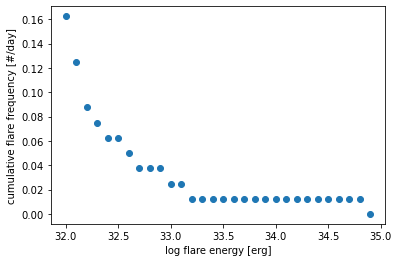

In [39]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(32.0, 35.0, 31))
print(hist, edges)
#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
plt.scatter(edges[:-1][::-1], np.cumsum(hist[::-1])/80) # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('cumulative flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
plt.savefig('ffd.png')
plt.show()

[3 3 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [32.  32.1 32.2 32.3 32.4 32.5 32.6 32.7 32.8 32.9 33.  33.1 33.2 33.3
 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4 34.5 34.6 34.7
 34.8 34.9 35. ]


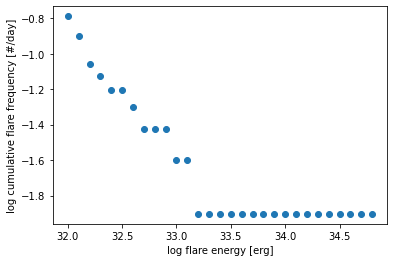

In [40]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(32.0, 35.0, 31))
print(hist, edges)
#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
plt.scatter(edges[:-1][::-1], np.log10(np.cumsum(hist[::-1])/80)) # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
plt.savefig('ffd.png')
plt.show()

I mean, that's not actually cumulative, is it, though? 

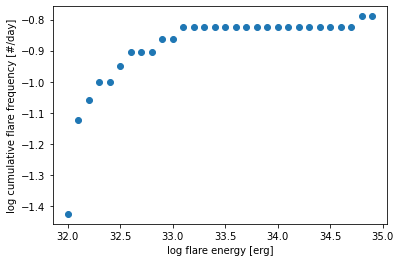

In [50]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(32.0, 35.0, 31))
#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
plt.scatter(edges[:-1], np.log10(np.cumsum(hist)/80)) # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
#plt.savefig('ffd.png')
plt.show()

Which one to use? The Davenport definition of cumulative FFD or this one? 

### Subtract flares

1511 1511 [0. 0. 0. ... 0. 0. 0.]


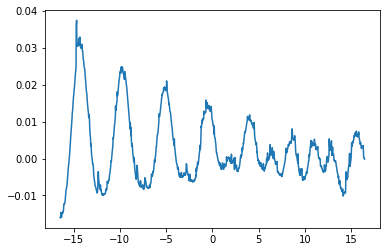

In [69]:
"""
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1000 + np.max(y[timemask]))
    ax.legend()
    
fig.delaxes(axes[5]) 
fig.tight_layout()
fig.savefig('flare-model-preflare.png')
"""
print(len(flc[1]), len(y), flc[1])
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

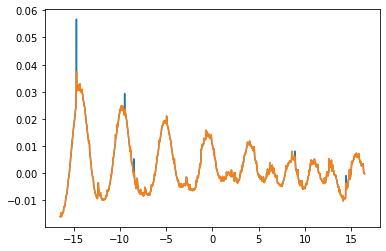

In [148]:
gp_mean = norm_y-flc[1] # mean for GP for total light curve fit is observed light curve - flare light curve

plt.plot(x, norm_y)
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

Get period of flare light curve-subtracted normalized observed light curve...note that this is the period of the star based only on the pre-superflare portion of the timeseries. I will reproduce this for the whole timeseries after verifying that this is the right way to go.

{'index': 166, 'log_power': -10.758044193215568, 'period': 4.442816869771975, 'period_uncert': 0.28579326385345427}


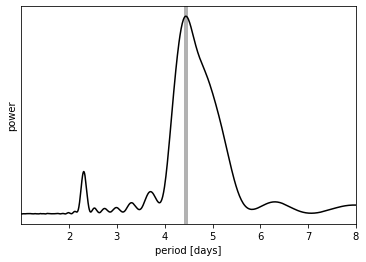

In [71]:
results = xo.estimators.lomb_scargle_estimator(
    x, gp_mean, max_peaks=1, min_period=1.0, max_period=8.0, samples_per_peak=50 # replaced y with gp_mean
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

In [82]:
print(gp_mean)
print(np.mean(gp_mean))
print(np.std(gp_mean))
print(norm_yerr)
print(np.mean(norm_yerr))
print(np.std(norm_yerr))

1      -0.015936
2      -0.015972
3      -0.016081
4      -0.015839
5      -0.014598
          ...   
1607    0.000469
1608    0.000106
1609    0.000113
1610   -0.000049
1611   -0.000154
Name: PDCSAP_FLUX, Length: 1511, dtype: float64
0.0025434808480807986
0.009383623057742341
1      -0.022793
2      -0.022212
3      -0.021701
4      -0.021135
5      -0.019555
          ...   
1607    0.002953
1608    0.002748
1609    0.002756
1610    0.002878
1611    0.003286
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
1.9400898e-06
0.0043283105


In [138]:
print(np.log(np.mean(norm_yerr)))
print(np.log(np.std(norm_yerr)))

-13.152777
-5.442578


In [335]:
peak['period']

4.442816869771975

### Model flare-subtracted light curve with pyMC3 and GP likelihood

In [196]:
# EXPLICITLY FOLLOWING EXOPLANET TUTORIAL: https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu=np.mean(norm_yerr), sd=np.std(norm_yerr)) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  
    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1236.9000309699934 -> nan


In [331]:
# okay, I got the period to work out. How about I don't fit every little spike now with my GP? 
# It works!! Hell yeah.
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(norm_yerr)), sd=np.log(np.std(norm_yerr))) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    #sigma = pm.InverseGamma(
    #    "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    #rho = pm.InverseGamma(
    #    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 2.5))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 1.5))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    #period = pm.Lognormal("period", mu=np.log(peak["period"]), sd=1.0) 
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  

    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0) # tweaking rho and sigma affects whether I'm touch-tight
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1354.6752148349344 -> 7233.330971065485


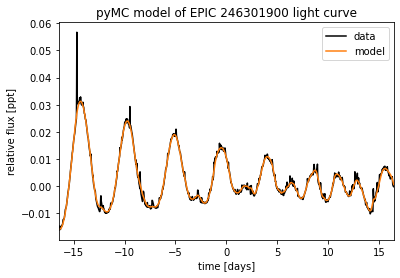

In [332]:
# plot maximum a posteriori model prediction

plt.plot(x, norm_y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("pyMC model of EPIC 246301900 light curve")
plt.show()

In [333]:
map_soln["pred"] - norm_y

1       0.000195
2       0.000190
3       0.000274
4       0.000023
5      -0.001212
          ...   
1607    0.001395
1608    0.001462
1609    0.001153
1610    0.001005
1611    0.000796
Name: PDCSAP_FLUX, Length: 1511, dtype: float64

In [334]:
map_soln

{'mean': array(0.00253776),
 'jitter_log__': array(-7.96011861),
 'sigma_log__': array(-0.0328942),
 'rho_log__': array(5.05688612),
 'sigma_rot_log__': array(0.13614409),
 'period': array(8.53805559),
 'Q0_log__': array(10.34711144),
 'dQ_log__': array(0.00013437),
 'f_interval__': array(-2.05329202),
 'jitter': array(0.00034911),
 'sigma': array(0.96764093),
 'rho': array(157.10056105),
 'sigma_rot': array(1.14584699),
 'Q0': array(31166.88532405),
 'dQ': array(1.00013438),
 'f': array(0.20234815),
 'pred': array([-0.01574052, -0.01578176, -0.0158071 , ...,  0.00126552,
         0.00095629,  0.00064153])}

In [336]:
# sample from posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]
INFO:pymc3:NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 426 seconds.
INFO:pymc3:Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 426 seconds.


In [339]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,0.148,0.066,0.100,0.254,0.001,0.001,5330.0,4730.0,5202.0,2940.0,1.0
dQ,8.009,54.187,0.000,21.941,0.984,0.727,3035.0,2780.0,6012.0,3836.0,1.0
Q0,707734.498,448419.679,126039.422,1457056.250,6894.671,5418.092,4230.0,3425.0,5750.0,3831.0,1.0
period,4.600,0.070,4.471,4.734,0.001,0.001,4612.0,4547.0,5211.0,2777.0,1.0
sigma_rot,1.136,0.156,0.858,1.435,0.002,0.002,5232.0,4834.0,5701.0,3367.0,1.0
rho,269.579,59.108,174.893,376.314,0.870,0.683,4620.0,3746.0,6062.0,3415.0,1.0
sigma,1.003,0.163,0.699,1.294,0.002,0.002,5986.0,5249.0,6646.0,3622.0,1.0
jitter,0.000,0.000,0.000,0.000,0.000,0.000,6807.0,6807.0,6753.0,3243.0,1.0
mean,0.002,0.009,-0.015,0.020,0.000,0.000,6765.0,2823.0,6795.0,3315.0,1.0


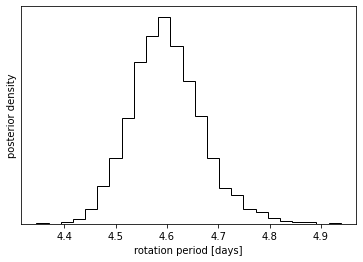

In [340]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")

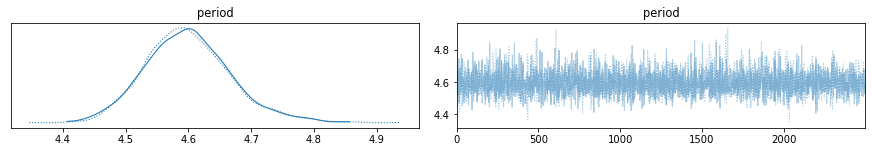

In [341]:
# show burn-in
import arviz as az

with model:
    az.plot_trace(trace, var_names=["period"])

Try with xoflare get_flare_integral_numerical method

In [49]:
def get_flare_integral_numerical(
    time, tpeak, fwhm, ampl, texp=None, oversample=7
):
    """
    used in testing flare integral
    """
    feval = get_light_curvenp(time, tpeak, fwhm, ampl, texp, oversample)
    tstart, tend = time[feval > 0][0], time[feval > 0][-1]
    integral = integrate.quad(
        get_light_curvenp,
        tstart,
        tend,
        points=tpeak,
        args=(tpeak, fwhm, ampl, texp, oversample),
    )
    return integral

def get_light_curvenp(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = np.asarray(time, dtype=float)

    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)

    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        texp = float(texp)
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2.0, texp / 2.0, oversample)
        tgrid = (dt + time.reshape(time.size, 1)).flatten()

    multiflare_lc = multiflaremodelnp(tgrid, tpeaks, fwhms, ampls)

    if texp is not None:
        multiflare_lc = np.mean(multiflare_lc.reshape(-1, oversample), axis=1)

    return multiflare_lc


In [157]:
flare_integrals = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_flare_integral_numerical(xx, tpeaksx, fwhmsx, amplsx))

ValueError: setting an array element with a sequence.